<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/TSFCII_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identificación del número completo de la fachada de las viviendas

Se empleará el **"The Street View House Numbers (SVHN) Dataset"**

El conjunto de datos SVHN, derivado de imágenes de Google Street View, contiene más de 600,000 imágenes de dígitos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


El objetivo es identificar el número completo de una vivienda (transcripción de secuencias). En la clasificación de imágenes tradicional (como en el dataset MNIST), el modelo recibe una imagen recortada de un solo dígito y debe asignar una etiqueta del 0 al 9. Sin embargo, un número de casa es una secuencia ordenada donde:

Longitud Variable: La red no sabe a priori cuántos dígitos componen el número. Puede ser un "5" aislado o un "12450".

Dependencia Espacial: La posición relativa es crucial. El sistema debe distinguir "12" de "21".

Ruido: Las imágenes de fachadas a menudo incluyen elementos distractores como marcos de puertas, vegetación, sombras proyectadas o incluso otros textos que deben ser ignorados.

Ese bloque descomprime archive.zip desde Drive a /content/svhn_zip y luego lista el contenido de la carpeta destino.

In [ ]:
# Rutas
ZIP_PATH    = "/content/drive/MyDrive/Proyecto-TSFCII/archive.zip"
EXTRACT_DIR = "/content/svhn_zip"

import os, zipfile
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extraer base de datos
if not os.path.exists(os.path.join(EXTRACT_DIR, "archive")):
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(EXTRACT_DIR)

print("ZIP extraído en:", EXTRACT_DIR)
print("Contenido:", os.listdir(EXTRACT_DIR))


ZIP extraído en: /content/svhn_zip
Contenido: ['crnn_resnet_final.keras', 'test', 'extra_32x32.mat', 'extra', 'test_digitStruct.mat', 'labels_test.csv', 'labels_train_extra.csv', 'crnn_transfer_best.weights.h5', 'test_32x32.mat', 'extra_digitStruct.mat', 'train', 'best.pt', '.ipynb_checkpoints', 'train_32x32.mat', 'train_digitStruct.mat']


In [ ]:
#CONFIGURACIÓN
import os, re, unicodedata
from pathlib import Path

# Raíz donde se descomprime SVHN, con estructura:
#   /content/svhn_zip/
#       ├─ train/train/*.png
#       ├─ extra/extra/*.png
#       ├─ test/test/*.png
#       ├─ train_digitStruct.mat
#       ├─ extra_digitStruct.mat
#       └─ test_digitStruct.mat

SVHN_ROOT = "/content/svhn_zip"

# Dónde se crea el dataset para entrenar YOLO
YOLO_OUT  = "/content/svhn_yolo_dataset"

# Mapa
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "test":  f"{SVHN_ROOT}/test/test",
    "extra": f"{SVHN_ROOT}/extra/extra",
}

# Quita nulls, espacios invisibles y normaliza separadores para evitar problemas al leer rutas
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")


Instalar Ultralytics Modelos YOLO

In [ ]:
!pip install ultralytics

In [ ]:
# PROCESAMIENTO SVHN (Street View House Numbers)
# 1. Leer archivos 'digitStruct.mat' (formato HDF5) de train, extra y test.
# 2. Limpiar los nombres de archivos que vienen sucios.
# 3. Extraer secuencias de dígitos y coordenadas de cajas.
# 4. Generar archivos CSV limpios para entrenar modelos.
# =============================================================================

import os
import csv
import re
import unicodedata
import h5py
import numpy as np
from pathlib import Path
from PIL import Image

# 1. CONFIGURACIÓN DE RUTAS
# Define dónde descomprimE el dataset.
SVHN_ROOT = "/content/svhn_zip"

# DICCIONARIO DE DIRECTORIOS:
# Mapea el nombre del split ('train', 'extra', 'test') a la ruta REAL
# LAS carpetas están anidadas como .../train/train
SPLIT_DIRS = {
    "train": f"{SVHN_ROOT}/train/train",
    "extra": f"{SVHN_ROOT}/extra/extra",
    "test":  f"{SVHN_ROOT}/test/test",
}

# 2. HERRAMIENTAS DE SANITIZADO (LIMPIEZA DE TEXTO)
# Detecta espacios, espacios de no separación (NBSP), ancho cero (ZWSP), BOM, etc.
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')

def sanitize_name(s: str) -> str:
    """
    Recibe un nombre de archivo sucio y lo devuelve limpio.
    SVHN tiene nombres con caracteres ocultos o codificaciones raras.
    """
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    s = s.replace("\\", "/")
    return s

#3. LECTURA INTERNA DE ARCHIVOS .MAT (HDF5)

def _read_name(f, names, i):
    """
    Lee el nombre del archivo i-ésimo dentro de la estructura  de HDF5.
    """
    # En HDF5, 'names[i][0]' es una REFERENCIA (puntero),
    ref = names[i][0]
    # Usamos la referencia para obtener el array de bytes real del archivo 'f'.
    arr = f[ref][:]
    try:
        # Intentamos decodificar bytes a string UTF-8 estándar.
        raw = bytes(arr).decode("utf-8")
    except Exception:
        # Si falla, convertimos cada entero a su caracter ASCII.
        raw = "".join(chr(int(c)) for c in arr.flatten())
        #Sanitizamos el nombre inmediatamente antes de devolverlo.
    return sanitize_name(raw)

def _read_list(f, box, key):
    """
    Extrae valores (coords, labels) de la estructura 'box'.
    Maneja el caso donde hay un solo dígito vs. múltiples dígitos.
    """
    dset = box[key] # Accedemos a la clave ( 'left', 'top', 'label')
    # Solo hay 1 dimensión/elemento (imagen con 1 solo dígito)
    if dset.shape[0] == 1:
        return [float(dset[0][0])]
    # Hay múltiples referencias (imagen con varios dígitos)
    vals = []
    for j in range(dset.shape[0]):
        ref = dset[j][0]          # Obtener referencia
        vals.append(float(f[ref][0][0])) # Desreferenciar y obtener valor
    return vals

# 4. EXTRACCIÓN DE DATOS: SECUENCIAS Y CAJAS
def read_digit_struct_pairs(mat_path, subdir):
    """
    Genera pares para CLASIFICACIÓN DE SECUENCIA COMPLETA.
    lista de tuplas -> [('train/1.png', '19'), ('train/2.png', '204'), ...]
    """
    pairs = []
    print(f"Abriendo {mat_path} ...")

    with h5py.File(mat_path, "r") as f:
        # Acceder a la jerarquía principal
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]

        # Iterar sobre cada imagen en el archivo .mat
        for i in range(len(names)):
            # 1. Leer nombre limpio
            name = _read_name(f, names, i)

            # 2. Leer caja (bbox) asociada a esa imagen
            box = f[bboxes[i][0]]

            # 3. Extraer coordenada 'left' (para ordenar) y 'label' (valor)
            left = np.array(_read_list(f, box, "left"))
            label = np.array(_read_list(f, box, "label"), dtype=int)

            # CORRECCIÓN: En SVHN, el dígito '0' está etiquetado como '10'. Lo corregimos.
            label = np.where(label==10, 0, label)

            # 4. Ordenar dígitos de Izquierda a Derecha basándonos en 'left'
            order = np.argsort(left)

            # 5. Construir el string de la secuencia (ej: [1, 9] -> "19")
            seq = "".join(str(int(label[j])) for j in order)

            # 6. Guardar ruta relativa ('train/imagen.png') y la etiqueta
            pairs.append((f"{subdir}/{name}", seq))

    return pairs

def read_digit_struct_boxes(mat_path, subdir):
    """
    Genera filas para DETECCIÓN DE OBJETOS
    Retorna: lista de tuplas con coordenadas individuales por dígito.
    Formato: ('subdir/name', x, y, w, h, label, order)
    """
    rows = []
    # (El proceso de apertura es idéntico al anterior)
    with h5py.File(mat_path, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]

        for i in range(len(names)):
            name = _read_name(f, names, i)
            box  = f[bboxes[i][0]]

            # Leemos TODAS las coordenadas
            left   = np.array(_read_list(f, box, "left"))
            top    = np.array(_read_list(f, box, "top"))
            width  = np.array(_read_list(f, box, "width"))
            height = np.array(_read_list(f, box, "height"))
            label  = np.array(_read_list(f, box, "label"), dtype=int)
            label  = np.where(label==10, 0, label) # Si es 10 -> 0

            # Ordenamos por posición izquierda
            order = np.argsort(left)

            # Guardamos UNA FILA POR CADA DÍGITO encontrado en la imagen
            for rank, j in enumerate(order, start=1):
                rows.append((
                    f"{subdir}/{name}",    # Ruta relativa limpia
                    float(left[j]),        # X
                    float(top[j]),         # Y
                    float(width[j]),       # W
                    float(height[j]),      # H
                    int(label[j]),         # Clase (0-9)
                    int(rank)              # Orden en la secuencia
                ))
    return rows

#5. GENERACIÓN DE ARCHIVOS CSV
# Definimos rutas de salida para los CSV
CSV_SEQ_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra.csv")
CSV_SEQ_TEST  = os.path.join(SVHN_ROOT, "labels_test.csv")
CSV_BOX_TRAIN = os.path.join(SVHN_ROOT, "labels_train_extra_boxes.csv")
CSV_BOX_TEST  = os.path.join(SVHN_ROOT, "labels_test_boxes.csv")

print("Iniciando procesamiento de metadatos...")

#GENERAR CSV DE SECUENCIAS (filename, label_completo)

pairs_train = []
# Combinamos 'train' y 'extra' para tener un dataset de entrenamiento mayyor
for split in ["train", "extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    if os.path.exists(matf):
        pairs_train.extend(read_digit_struct_pairs(matf, split))
    else:
        print(f"ADVERTENCIA: No se encontró {matf}")

# Escribir CSV Train+Extra
with open(CSV_SEQ_TRAIN, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename","label"]) # Encabezado
    w.writerows(pairs_train)

# Procesar Test
pairs_test = read_digit_struct_pairs(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_SEQ_TEST, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename","label"])
    w.writerows(pairs_test)


#GENERAR CSV DE CAJAS/BOXES (x, y, w, h por dígito)

rows_train = []
for split in ["train","extra"]:
    matf = os.path.join(SVHN_ROOT, f"{split}_digitStruct.mat")
    if os.path.exists(matf):
        rows_train.extend(read_digit_struct_boxes(matf, split))

with open(CSV_BOX_TRAIN, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_train)

rows_test = read_digit_struct_boxes(os.path.join(SVHN_ROOT, "test_digitStruct.mat"), "test")
with open(CSV_BOX_TEST, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename","x","y","w","h","label","order"])
    w.writerows(rows_test)

print("\n CSVs escritos exitosamente:")
print(f"  - {CSV_SEQ_TRAIN}")
print(f"  - {CSV_SEQ_TEST}")
print(f"  - {CSV_BOX_TRAIN}")
print(f"  - {CSV_BOX_TEST}")

# 6. VERIFICACIÓN Y CHEQUEO DE RUTAS

def resolve_path_from_csv(rel_path: str, split_dirs: dict) -> Path:
    """
    Convierte la ruta relativa del CSV (ej: 'extra/1.png')
    a la ruta ABSOLUTA del sistema (ej: '/content/svhn/extra/extra/1.png').
    """
    # Resanitizar por seguridad
    rel_path = sanitize_name(rel_path)
    rel_path = rel_path.replace("\\", "/")

    # Dividir en 'carpeta' y 'archivo' (ej: 'train' y '1.png')
    parts = rel_path.split("/", 1)
    assert len(parts) == 2, f"Ruta mal formada en CSV: {rel_path}"

    split, rest = parts[0], parts[1]

    # Buscar la ruta base real en el diccionario SPLIT_DIRS
    base = split_dirs.get(split)
    if not base:
        raise ValueError(f"Split desconocido: {split}")

    return Path(base) / rest

# Chequeo
print("\n Verificando acceso a las primeras 10 imágenes del CSV ")

# Leemos las primeras filas del CSV recién creado
with open(CSV_SEQ_TRAIN, "r") as f:
    rows = list(csv.reader(f))[1:] # Saltamos encabezado

ok_count = 0
check_limit = 10

for rel, _ in rows[:check_limit]:
    try:
        # Resolver ruta completa
        p = resolve_path_from_csv(rel, SPLIT_DIRS)
        print(f" Probando: {p}")

        # Verificar existencia
        if p.exists():
            # Prueba de fuego: intentar abrir la imagen con Pillow
            with Image.open(p) as img:
                img.convert("RGB") # Forzar carga de píxeles
            ok_count += 1
        else:
            print(f" ERROR: El archivo no existe: {p}")

    except Exception as e:
        print(f"ERROR DE LECTURA: {e}")

print(f"\n Resultado: {ok_count}/{check_limit} imágenes abiertas correctamente")

Este código implementa un (pipeline) Tomar el conjunto de datos SVHN, procesarlo y limpiarlo, y luego utilizar esos datos para entrenar un modelo de visión YOLOv8, automatizando pasos que normalmente se harían por separado: extracción de datos, conversión de etiquetas, configuración de aumentos de datos específicos para texto (OCR) y el entrenamiento final.

In [ ]:
# ==================================================================================
# MAESTRO SVHN YOLOv8: Pipeline Completo & Optimizado (Colab T4 High-RAM)
# ==================================================================================
import os, re, unicodedata
import numpy as np
from PIL import Image
import h5py
import torch
import shutil

#0. VERIFICACIÓN DE ENTORNO ---
print(" Verificando hardware")
if torch.cuda.is_available():
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    torch.cuda.empty_cache()
    print(f"   🔥 GPU Detectada: {torch.cuda.get_device_name(0)}")
    print(f"   🧠 VRAM Disponible: {vram:.1f} GB")
else:
    print(" NO SE DETECTA GPU.")

# ----------------- CONFIGURACIÓN GLOBAL -----------------
# Rutas
RAIZ_SVHN   = "/content/svhn_zip"              # Carpeta donde descomprimiste SVHN
SALIDA_YOLO = "/content/svhn_yolo_dataset"     # Carpeta destino para YOLO
DATA_YAML   = os.path.join(SALIDA_YOLO, "svhn_yolo.yaml")
SEED        = 42 #significado de la vida

RUN_CONVERSION = True   # True para la re-conversión de datos

# Hiperparámetros de Entrenamiento
PESOS_BASE  = "yolov8s.pt"       # Modelo 'Small'
NOMBRE_RUN  = "svhn_yolov8s_640_pro"
EPOCAS      = 100
IMG_SIZE    = 640                # 640px
BATCH       = -1                 # AUTOBATCH(aprox 32-64 imgs)
PATIENCE    = 15                 # Early Stopping

# 1. UTILIDADES DE LIMPIEZA
_WS = re.compile(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+')
def sanitize_name(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "")
    s = s.replace("\x00", "")
    s = _WS.sub("", s)
    s = s.strip(' "\'')
    return s.replace("\\", "/")

def asegurar_dir(p): os.makedirs(p, exist_ok=True)

# 2. LECTURA DE MATADATOS (MATLAB)
def leer_digit_struct(mat_path):
    out = []
    if not os.path.exists(mat_path):
        print(f"  Archivo no encontrado: {mat_path}")
        return []

    print(f"   📂 Leyendo estructura: {os.path.basename(mat_path)} ...")
    with h5py.File(mat_path, 'r') as f:
        names  = f['digitStruct']['name']
        bboxes = f['digitStruct']['bbox']

        # Helpers internos para leer h5py referencias
        def _get_name(i):
            ref = names[i][0]
            arr = f[ref][:]
            try: return sanitize_name(bytes(arr).decode('utf-8'))
            except: return sanitize_name(''.join(chr(int(c)) for c in arr.flatten()))

        def _get_list(bb, key):
            dset = bb[key]
            if dset.shape[0] == 1: return [float(dset[0][0])]
            vals = []
            for j in range(dset.shape[0]):
                ref = dset[j][0]
                vals.append(float(f[ref][0][0]))
            return vals

        total = len(names)
        for i in range(total):
            name = _get_name(i)
            bb   = f[bboxes[i][0]]
            out.append({
                'name': name,
                'labels': [int(x) for x in _get_list(bb, 'label')],
                'left':   _get_list(bb, 'left'),
                'top':    _get_list(bb, 'top'),
                'width':  _get_list(bb, 'width'),
                'height': _get_list(bb, 'height')
            })
            if (i+1) % 50000 == 0:
                print(f"      Procesados {i+1}/{total} registros...")
    return out

# 3. CONVERSIÓN A YOLO
def convertir_split(split_svhn, split_yolo):
    print(f"→ Procesando Split: '{split_svhn}' hacia '{split_yolo}'...")
    dir_imgs = os.path.join(RAIZ_SVHN, split_svhn, split_svhn)
    mat_path = os.path.join(RAIZ_SVHN, f"{split_svhn}_digitStruct.mat")

    ann = leer_digit_struct(mat_path)
    if not ann: return

    out_img = os.path.join(SALIDA_YOLO, "images", split_yolo)
    out_lbl = os.path.join(SALIDA_YOLO, "labels", split_yolo)
    asegurar_dir(out_img); asegurar_dir(out_lbl)

    count = 0
    for a in ann:
        base = f"{split_svhn}_{a['name']}" # Prefijo único
        src  = os.path.join(dir_imgs, a['name'])
        dst  = os.path.join(out_img, base)

        if not os.path.isfile(src): continue

        try:
            with Image.open(src) as im:
                im.save(dst)
                w_img, h_img = im.size
        except: continue # Imagen corrupta, saltar

        # Generar .txt YOLO
        txt_path = os.path.join(out_lbl, os.path.splitext(base)[0] + ".txt")
        with open(txt_path, "w") as f:
            for lab, L, T, W, H in zip(a['labels'], a['left'], a['top'], a['width'], a['height']):
                # SVHN: 10=0, 1=1...
                digit = 0 if int(lab) == 10 else int(lab)

                # Normalizar xywh (0-1)
                cx = (L + W/2.0) / w_img
                cy = (T + H/2.0) / h_img
                wn = W / w_img
                hn = H / h_img

                # Clipping de seguridad
                cx = max(0, min(1, cx)); cy = max(0, min(1, cy))
                wn = max(0, min(1, wn)); hn = max(0, min(1, hn))

                f.write(f"{digit} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}\n")

        count += 1
        if count % 10000 == 0: print(f"   Imágenes generadas: {count}...")

    print(f"✔ Fin {split_svhn}. Total válidas: {count}")

def crear_yaml():
    contenido = f"""
path: {SALIDA_YOLO}
train: images/train
val: images/val
nc: 10
names: ["0","1","2","3","4","5","6","7","8","9"]
"""
    with open(DATA_YAML, "w") as f: f.write(contenido)
    print(f"YAML Config creado en: {DATA_YAML}")

# --- Ejecución Conversión ---
if RUN_CONVERSION or not os.path.exists(DATA_YAML):
    print("\n INICIANDO CONVERSIÓN DE DATASET")
    # Limpiar si existe para evitar duplicados
    if os.path.exists(SALIDA_YOLO): shutil.rmtree(SALIDA_YOLO)

    convertir_split("train", "train")
    convertir_split("extra", "train") # 'extra' va al train para mejor precisión
    convertir_split("test",  "val")
    crear_yaml()
else:
    print("\n Dataset YOLO detectado. Saltando conversión.")


# 4. ENTRENAMIENTO
print(f"\n INICIANDO ENTRENAMIENTO YOLOv8")
print(f"    Config: {PESOS_BASE} |  Size: {IMG_SIZE} |  RAM Cache: ACTIVADO")

try:
    from ultralytics import YOLO

    # Cargar pesos pre-entrenados
    model = YOLO(PESOS_BASE)

    # Entrenar
    model.train(
        data=DATA_YAML,
        project=os.path.join(SALIDA_YOLO, "runs"),
        name=NOMBRE_RUN,

        epochs=EPOCAS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        cache=True,
        workers=8,

        patience=PATIENCE,
        seed=SEED,
        exist_ok=True,      # Sobreescribir carpeta run si existe
        save_period=10,     # Guardar pesos cada 10 epocas
        plots=True,         # Guardar curvas de loss/map

        # DATA AUGMENTATION
        degrees=10.0,       # Rotación ligera (+/- 10°)
        translate=0.1,      # Mover imagen 10%
        scale=0.5,          # Escalar +/- 50%
        shear=0.0,          # Deformar: NO
        perspective=0.0,    # Perspectiva: NO

        flipud=0.0,         # ESPEJO VERTICAL APAGADO (evita 6 <-> 9)
        fliplr=0.0,         # ESPEJO HORIZONTAL APAGADO (evita 3 <-> E)

        mosaic=1.0,         # Mosaic ayuda a detectar objetos juntos
        mixup=0.0,          # Mixup apagado (confunde OCR)
        close_mosaic=10
    )

    # Validación Final
    print("\n Entrenamiento finalizado. Validando mejor modelo...")
    metrics = model.val(data=DATA_YAML, imgsz=IMG_SIZE, batch=BATCH)

    ruta_best = os.path.join(SALIDA_YOLO, "runs", NOMBRE_RUN, "weights", "best.pt")
    print(f"\n MEJOR MODELO GUARDADO EN:\n   {ruta_best}")
    print("   (Usa este archivo .pt para tus predicciones)")

except ImportError:
    print(" Error: Librería 'ultralytics' no instalada.")
    print("   Ejecuta: !pip install ultralytics")
except Exception as e:
    print(f" Error crítico en entrenamiento: {e}")


🔍 Verificando hardware...
   🔥 GPU Detectada: NVIDIA A100-SXM4-80GB
   🧠 VRAM Disponible: 85.2 GB (Ideal para AutoBatch)

⚙️  INICIANDO CONVERSIÓN DE DATASET...
→ Procesando Split: 'train' hacia 'train'...
   📂 Leyendo estructura: train_digitStruct.mat ...
   Imágenes generadas: 10000...
   Imágenes generadas: 20000...
   Imágenes generadas: 30000...
✔ Fin train. Total válidas: 33402
→ Procesando Split: 'extra' hacia 'train'...
   📂 Leyendo estructura: extra_digitStruct.mat ...
      Procesados 50000/202353 registros...
      Procesados 100000/202353 registros...
      Procesados 150000/202353 registros...
      Procesados 200000/202353 registros...
   Imágenes generadas: 10000...
   Imágenes generadas: 20000...
   Imágenes generadas: 30000...
   Imágenes generadas: 40000...
   Imágenes generadas: 50000...
   Imágenes generadas: 60000...
   Imágenes generadas: 70000...
   Imágenes generadas: 80000...
   Imágenes generadas: 90000...
   Imágenes generadas: 100000...
   Imágenes generadas

KeyboardInterrupt: 

Datos unidos correctamente. Total de épocas: 41


/tmp/ipython-input-3646130761.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


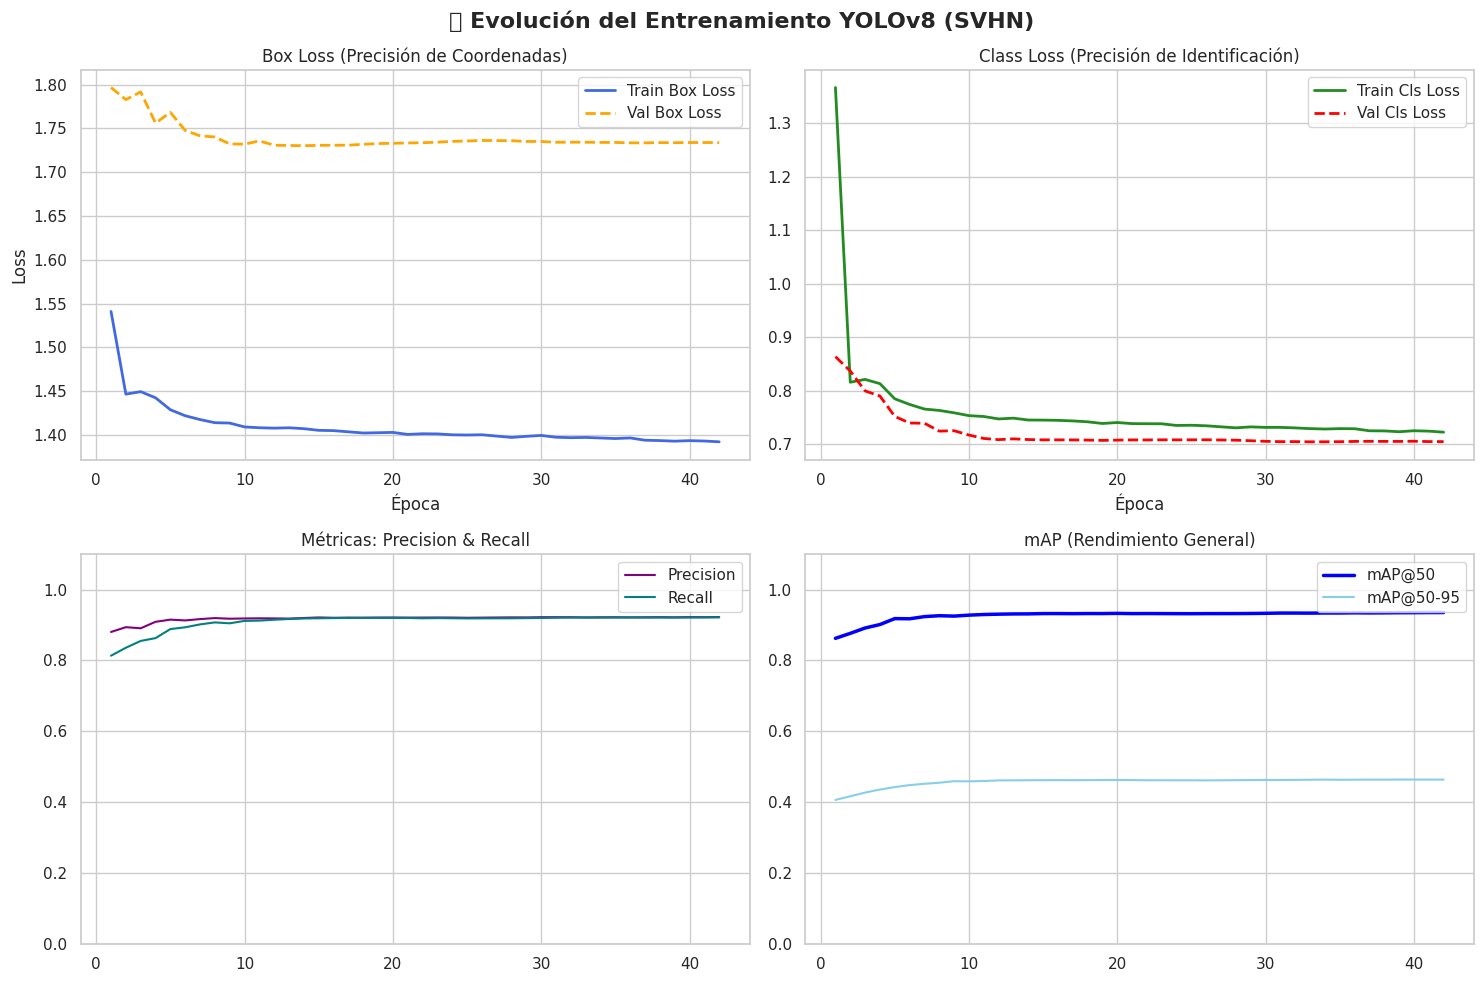

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CARGA DE DATOS
# Cargamos ambos archivos
try:
    df1 = pd.read_csv('results (1).csv') # El que empieza en epoch 1
    df2 = pd.read_csv('results.csv')     # El que sigue en epoch 28

    # Limpiamos los nombres de las columnas (YOLO suele dejar espacios vacíos)
    df1.columns = df1.columns.str.strip()
    df2.columns = df2.columns.str.strip()

    # Unimos los dataframes en uno solo
    df = pd.concat([df1, df2])

    # Ordenamos por época para asegurar continuidad y reseteamos el índice
    df = df.sort_values(by='epoch').drop_duplicates(subset=['epoch'], keep='last')

    print(f"Datos unidos correctamente. Total de épocas: {len(df)}")

except FileNotFoundError:
    print(" No encontré los dos archivos, asegúrate de subirlos al entorno.")
    # Fallback por si solo tienes uno subido
    df = pd.read_csv('results.csv')
    df.columns = df.columns.str.strip()

# 2. CONFIGURACIÓN VISUAL
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('📈 Evolución del Entrenamiento YOLOv8 (SVHN)', fontsize=16, fontweight='bold')

# --- GRÁFICA A: PÉRDIDA DE CAJA (BOX LOSS) ---
# Mide qué tan bien dibuja los rectángulos alrededor de los números
ax[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='royalblue', linewidth=2)
ax[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange', linestyle='--', linewidth=2)
ax[0,0].set_title('Box Loss (Precisión de Coordenadas)')
ax[0,0].set_xlabel('Época')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()

# --- GRÁFICA B: PÉRDIDA DE CLASE (CLS LOSS) ---
# Mide qué tan bien adivina si es un "1", "2", "3", etc.
ax[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='forestgreen', linewidth=2)
ax[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='red', linestyle='--', linewidth=2)
ax[0,1].set_title('Class Loss (Precisión de Identificación)')
ax[0,1].set_xlabel('Época')
ax[0,1].legend()

# --- GRÁFICA C: PRECISIÓN Y RECALL ---
# Precision: De lo que digo que es un número, ¿cuánto es verdad?
# Recall: De todos los números que hay, ¿cuántos encontré?
ax[1,0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
ax[1,0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='teal')
ax[1,0].set_title('Métricas: Precision & Recall')
ax[1,0].set_ylim(0, 1.1) # Escala de 0 a 100%
ax[1,0].legend()

# --- GRÁFICA D: mAP (LA MÉTRICA REINA) ---
# mAP50: Precisión general aceptando errores leves.
# mAP50-95: Precisión estricta (muy exigente).
ax[1,1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='blue', linewidth=2.5)
ax[1,1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', color='skyblue', linewidth=1.5)
ax[1,1].set_title('mAP (Rendimiento General)')
ax[1,1].set_ylim(0, 1.1)
ax[1,1].legend()

plt.tight_layout()
plt.show()

Aprendizaje Rápido (Transfer Learning)

Epoch 1: Ya tenía un mAP50 del 86%. Porque usamos yolov8s.pt pre-entrenado. El modelo ya sabía "ver" bordes y formas; solo tuvo que aprender que "esas formas" eran números. Esto valida que la estrategia de Transfer Learning funcionó.

Rendimiento (Plateau)

Entre la época 15 y la 33, la línea de precisión (mAP50) se aplana alrededor del 93.2% - 93.3%. El modelo convergió (llegó a su máximo potencial con estos hiperparámetros) muy rápido. Un 93% de precisión en SVHN es un resultado.

Pérdida (Loss)
Train Loss (Azul/Verde): Bajó constantemente (de 1.54 a 1.39). Esto significa que la red está aprendiendo y memorizando bien los datos de entrenamiento.

Val Loss (Naranja/Roja): Bajó de 1.79 a 1.73 y se mantuvo estable. La brecha entre Train y Val es pequeña y estable. No hay signos graves de Overfitting.

# **Estrategia de entrenamiento**

Detección en dos etapas):

Localizador (YOLO): Encuentra dónde hay un número (te da el recorte).

Clasificador: Mira el recorte y dice qué número es (0-9).

Paso 1: El Dataset para la Red Sencilla
Para entrenar un clasificador de números, no necesitas las imágenes completas de las casas. Necesitas recortes individuales de dígitos.

Opción A: Usar MNIST (El "Hola Mundo" de la IA) Ya viene listo en Keras, son 60,000 dígitos manuscritos de 28x28. Son manuscritos (a mano), y SVHN son impresos (casas). A veces el modelo no transfiere bien.

Opción B: Usar SVHN Cropped
El dataset SVHN tiene una versión llamada "Cropped Digits" (Dígitos recortados) donde cada imagen es un solo número de 32x32.

Paso 2: La Arquitectura "Sencilla" (Clasificador CNN)
Entrada: Imagen 32x32 (RGB o Grises).
Conv2D + MaxPool: 3 bloques para extraer bordes y formas.
Flatten: Aplanar los datos.
Dense (Full Connected): El "cerebro" final.
Salida: 10 neuronas (Clases 0-9) con softmax.

La Distancia de Levenshtein es una métrica matemática que te dice qué tan diferentes son dos palabras. Mide el número mínimo de cambios (inserciones, eliminaciones o sustituciones) necesarios para transformar una palabra en la otra.

Instalar esta librería te permitirá calcular la tasa de error a nivel de caracteres (CER - Character Error Rate), que es la métrica para saber qué tan bueno es el modelo leyendo secuencias largas de números.

In [ ]:
!pip install python-Levenshtein

http://ufldl.stanford.edu/housenumbers/

El modelo es una Red Neuronal Convolucional Recurrente (CRNN). Funciona en dos etapas:

El Ojo (CNN - ResNet):
Usa una Red Convolucional personalizada similar a ResNet (get_resnet_backbone).

Su trabajo es mirar la imagen de 32x128 píxeles y extraer características visuales (bordes, curvas, formas) reduciendo la imagen a una secuencia de 16 "pasos temporales" con 512 características cada uno.

El Cerebro (RNN - LSTM):
Usa capas Bidireccionales LSTM (layers.Bidirectional(layers.LSTM)).

Su trabajo es leer esa secuencia de características de izquierda a derecha (y viceversa) para entender el contexto y predecir qué caracteres hay en cada paso.

La Salida (CTC):
Usa la pérdida CTC (Connectionist Temporal Classification).

Permite entrenar la red sin necesidad de decirle exactamente dónde está cada letra en la imagen. Solo le dices "aquí dice 123" y la red aprende a alinear la imagen con el texto automáticamente.

In [ ]:
# ==============================================================================
# BLOQUE 1: SETUP, ARQUITECTURA Y DEFINICIONES DE FUNCIONES
# ==============================================================================

# --- DEPENDENCIAS ---
import os, csv, re, unicodedata, random, time
from pathlib import Path
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

# --- 1. CONFIGURACIÓN GLOBAL Y HARDWARE ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Detección y Configuración de Precisión (Estabilidad A100/L4)
try:
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
    print(f" Hardware OK: Usando política {policy.compute_dtype}")
except:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

# Parámetros (Estables para CTC)
IMG_H, IMG_W = 32, 128
BATCH_CRNN = 64
LR_CRNN = 1e-4
EPOCHS = 100
PATIENCE = 15
MIN_DELTA = 1e-4

RAIZ_SVHN = "/content/svhn_zip"
ALFABETO = "0123456789"
INDICE_BLANCO = len(ALFABETO) #10
NUM_CLASES = len(ALFABETO) + 1
CRNN_MEJOR_WEIGHTS = os.path.join("/content/svhn_zip", "crnn_transfer_best.weights.h5")
CSV_TRAIN = os.path.join(RAIZ_SVHN, "labels_train_extra.csv")
CSV_TEST = os.path.join(RAIZ_SVHN, "labels_test.csv")
SPLIT_DIRS = {"train": f"{RAIZ_SVHN}/train/train", "extra": f"{RAIZ_SVHN}/extra/extra", "test": f"{RAIZ_SVHN}/test/test"}
# ==============================================================================
# 2. UTILIDADES DE DATOS Y ARQUITECTURA
# ==============================================================================
def str_a_ints(s): return [ord(c)-ord('0') for c in s]

def sanear(s: str) -> str:
    s = unicodedata.normalize("NFKC", s or "").replace("\x00", "").strip(' "\'')
    return re.sub(r'[\s\u00A0\u2000-\u200B\u202F\u205F\u3000\uFEFF]+', "", s).replace("\\", "/")

def resolver_abs_desde_rel(rel_path: str) -> Path:
    rel_path = sanear(rel_path)
    parts = rel_path.split("/", 1)
    if len(parts) == 2 and parts[0] in SPLIT_DIRS:
        return Path(SPLIT_DIRS[parts[0]]) / parts[1]
    return Path(rel_path)

def cargar_pairs_csv(csv_file: str):
    """Carga pares (ruta_imagen, etiqueta) desde el CSV."""
    if not os.path.exists(csv_file): return []
    with open(csv_file, "r") as f:
        rdr = list(csv.reader(f))
    start = 1 if (len(rdr)>0 and "filename" in rdr[0][0].lower()) else 0
    crudos = [(sanear(r[0]), sanear(r[1])) for r in rdr[start:] if len(r)>=2]
    out = []
    for rel, lab in crudos:
        try: p = resolver_abs_desde_rel(rel)
        except: continue
        if p.exists(): out.append((str(p), lab))
    return out

# --- 3. FUNCIONES DE PREPROCESAMIENTO TF.DATA ---
def preprocess_raw_crnn(path):
    """Carga, redimensiona y normaliza la imagen a [-1, 1]."""
    data = tf.io.read_file(path); img = tf.image.decode_png(data, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    h = tf.cast(tf.shape(img)[0], tf.float32); w = tf.cast(tf.shape(img)[1], tf.float32)
    new_w = tf.cast(tf.math.maximum(1.0, tf.math.round(w * (IMG_H / h))), tf.int32)
    img = tf.image.resize(img, size=(IMG_H, new_w))
    if tf.less(new_w, IMG_W):
        img = tf.pad(img, [[0,0],[0,IMG_W-new_w],[0,0]], constant_values=0.5)
    else:
        img = tf.image.crop_to_bounding_box(img, 0, 0, IMG_H, IMG_W)
    return (img - 0.5) / 0.5

def make_dataset_crnn(pairs_list):
    """Crea el dataset de TensorFlow con cacheo en RAM."""
    paths = [p for p,_ in pairs_list]; labs = [str_a_ints(l) for _,l in pairs_list]
    lens = [len(v) for v in labs]; max_l = max(lens)
    labs_pad = [np.pad(np.array(v, dtype=np.int32), (0, max_l-len(v)), constant_values=-1) for v in labs]

    ds = tf.data.Dataset.from_tensor_slices((paths, np.array(labs_pad, dtype=np.int32), np.array(lens, dtype=np.int32)))
    ds = ds.map(lambda p, l, ln: (preprocess_raw_crnn(p), l, ln), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_CRNN).prefetch(tf.data.AUTOTUNE) # Cache en RAM (A100)
    return ds

# --- 4. ARQUITECTURA (RESNET-LIKE) ---
def res_block(x, filters):
    """Define el Bloque Residual básico (ResNet-like)."""
    short = layers.Conv2D(filters, 1, padding="same")(x)
    res = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, 3, padding="same")(res)
    return layers.Add()([short, res])

def get_resnet_backbone(input_shape):
    """Define el Extractor de Características CNN."""
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)

    x = res_block(x, 128); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 256); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 512); x = layers.MaxPool2D((2,2))(x)
    return keras.Model(inputs, x, name="Visual_Backbone")

def build_transfer_crnn_final():
    """Define el Modelo CRNN final para el Fine-Tuning."""
    inputs = keras.Input(shape=(32, 128, 3))
    visual_expert = get_resnet_backbone((32, 128, 3))

    # Carga de pesos (Transferencia de Aprendizaje)
    if os.path.exists("visual_weights.weights.h5"):
        # FIX: Eliminamos by_name=True para compatibilidad con Keras 3
        visual_expert.load_weights("visual_weights.weights.h5", skip_mismatch=True)

    x = visual_expert(inputs)
    x = layers.Reshape((16, 512))(x) # Reshape para 16 time steps

    # RNN + CTC
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)

    return keras.Model(inputs, logits, name="CRNN_Transfer")

# --- 5. FUNCIONES DE ENTRENAMIENTO COMPILADAS ---
def dense_to_sparse_tensor(dense, lens):
    B = tf.shape(dense)[0]; max_len = tf.shape(dense)[1]
    indices = tf.where(tf.not_equal(dense, -1)); values = tf.gather_nd(dense, indices)
    shape = tf.cast([B, max_len], tf.int64); return tf.SparseTensor(indices, values, shape)

@tf.function
def ctc_loss_safe(y_true_sparse, y_pred, label_len, logit_len):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_tm = tf.transpose(y_pred, [1,0,2])
    loss = tf.nn.ctc_loss(labels=y_true_sparse, logits=y_pred_tm, label_length=label_len, logit_length=logit_len, logits_time_major=True, blank_index=INDICE_BLANCO)
    return tf.reduce_mean(loss)

@tf.function
def train_step(imgs, lbl_dense, lbl_len, model, optimizer, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    with tf.GradientTape() as tape:
        logits = model(imgs, training=True)
        loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(imgs, lbl_dense, lbl_len, model, dummy_T):
    logit_len = tf.fill([tf.shape(imgs)[0]], dummy_T)
    lbl_sparse = dense_to_sparse_tensor(lbl_dense, lbl_len)
    logits = model(imgs, training=False)
    loss = ctc_loss_safe(lbl_sparse, logits, lbl_len, logit_len)
    return loss
def load_mat_data_direct(path):
    """Carga y preprocesa el archivo .mat para el pre-entrenamiento."""

    # Asume que el archivo ya está en el sistema de archivos (localmente, no en URL)

    # Revisa si el archivo existe antes de cargar (aunque el bucle lo hace)
    if not os.path.exists(path):
        raise FileNotFoundError(f" ERROR: El archivo {os.path.basename(path)} no existe en la ruta de Colab.")

    data = sio.loadmat(path)
    # Formato original: (32, 32, 3, N) -> Queremos (N, 32, 32, 3)
    x = np.transpose(data['X'], (3, 0, 1, 2))
    y = data['y']
    y[y == 10] = 0 # Corregir etiqueta 10 -> 0 (Dígito Cero)
    return x, y

🔥 Hardware OK: Usando política bfloat16


In [ ]:
# --- 6. EJECUCIÓN: CARGA INICIAL DE LISTAS DE DATOS ---
pairs_all = cargar_pairs_csv(CSV_TRAIN)
val_n = int(0.05 * len(pairs_all)); idxs = np.arange(len(pairs_all)); np.random.RandomState(SEED).shuffle(idxs)
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]; pairs_train = [pairs_all[i] for i in tr_idx]; pairs_val = [pairs_all[i] for i in val_idx]

print(f"Carga Inicial: Train/Val listos ({len(pairs_train)}/{len(pairs_val)})")

Carga Inicial: Train/Val listos (223968/11787)


Diseño para pre-entrenar el "ojo" de la red (el backbone CNN tipo ResNet) antes de abordar la tarea más compleja de leer secuencias completas. El código verifica primero si ya existen pesos guardados; si no, carga y fusiona los conjuntos de datos de dígitos individuales recortados (train y extra de SVHN) para crear un dataset masivo de entrenamiento. Con estos datos, construye y entrena un modelo clasificador temporal durante 20 épocas para que aprenda a distinguir dígitos del 0 al 9 con alta precisión. Finalmente, el sistema descarta la parte clasificadora y guarda únicamente los pesos aprendidos por la red convolucional en el archivo visual_weights.weights.h5, los cuales servirán como una inicialización "inteligente" para el modelo CRNN final, acelerando su convergencia y mejorando su capacidad para extraer características visuales.

In [ ]:
# ==============================================================================
# BLOQUE 2: ETAPA 1 (PRE-ENTRENAMIENTO PARA GENERAR PESOS VISUALES)
# ==============================================================================
if not os.path.exists("visual_weights.weights.h5"):
    print("\n" + "="*50)
    print(" INICIANDO ETAPA 1: Pre-entrenamiento (CON DATOS EXPANDIDOS)")

    # --- 1. DEFINICIÓN DE RUTAS DE CARGA ---
    PATH_TRAIN_MAT = os.path.join("/content/svhn_zip", "train_32x32.mat")
    PATH_EXTRA_MAT = os.path.join("/content/svhn_zip", "extra_32x32.mat")

    if not os.path.exists(PATH_TRAIN_MAT):
        print(f" ERROR CRÍTICO: Falta el archivo base {os.path.basename(PATH_TRAIN_MAT)}. Deteniendo.")
        exit()

    # --- 2. CARGA Y PROCESAMIENTO ---

    # Cargar conjunto TRAIN
    X_train, y_train = load_mat_data_direct(PATH_TRAIN_MAT)
    print(f"   Datos de TRAIN cargados: {X_train.shape[0]} imágenes.")

    # Cargar conjunto EXTRA (Si existe)
    if os.path.exists(PATH_EXTRA_MAT):
        X_extra, y_extra = load_mat_data_direct(PATH_EXTRA_MAT)
        print(f"   Datos de EXTRA cargados: {X_extra.shape[0]} imágenes.")

        # CONCATENACIÓN: Usar todo el dataset disponible
        X_combined = np.concatenate([X_train, X_extra], axis=0)
        y_combined = np.concatenate([y_train, y_extra], axis=0)
    else:
        print(" Archivo extra_32x32.mat no encontrado. Usando solo el set base.")
        X_combined = X_train
        y_combined = y_train

    # Normalizar (0-255 -> 0-1)
    X_single_norm = X_combined.astype('float32') / 255.0

    # 3. Montar y entrenar experto visual
    backbone = get_resnet_backbone((32, 32, 3))
    inputs = keras.Input((32, 32, 3)); x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x); outputs = layers.Dense(10, activation='softmax', dtype='float32')(x)
    teacher_model = keras.Model(inputs, outputs)

    teacher_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f"   ⏳ Iniciando pre-entrenamiento (20 epochs) en {X_combined.shape[0]} imágenes...")

    # El fit usa el conjunto combinado
    history_teacher = teacher_model.fit(
        X_single_norm, y_combined,
        batch_size=128,
        epochs=20,
        validation_split=0.2, # Usar 20% del conjunto combinado para validación
        verbose=1
    )

    # 3. Guardar los pesos para la transferencia
    backbone.save_weights("visual_weights.weights.h5")
    print("ETAPA 1 COMPLETADA. Pesos visuales guardados.")
    tf.keras.backend.clear_session()
else:
    print("\n ETAPA 1 OMITIDA: Pesos visuales ya existen (visual_weights.weights.h5).")


 INICIANDO ETAPA 1: Pre-entrenamiento (CON DATOS EXPANDIDOS)
   Datos de TRAIN cargados: 73257 imágenes.
   Datos de EXTRA cargados: 531131 imágenes.
   ⏳ Iniciando pre-entrenamiento (20 epochs) en 604388 imágenes...
Epoch 1/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - accuracy: 0.8257 - loss: 0.5717 - val_accuracy: 0.9607 - val_loss: 0.1308
Epoch 2/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.9656 - loss: 0.1223 - val_accuracy: 0.9743 - val_loss: 0.0937
Epoch 3/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.9727 - loss: 0.1001 - val_accuracy: 0.9659 - val_loss: 0.1159
Epoch 4/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9762 - loss: 0.0871 - val_accuracy: 0.9738 - val_loss: 0.0954
Epoch 5/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9789 - loss: 0.0766 - val_accuracy: 0.9768 - val_loss: 0.0878
Epoch 6/20
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9809 - loss: 0.0691 - val_accuracy: 0.9764 - val_loss: 0


📊 REPORTE DE TRANSFERENCIA (Etapa 1):
   Precisión Final en Datos de Test (Accuracy): 94.63%
   Pérdida Final (Loss): 0.3387


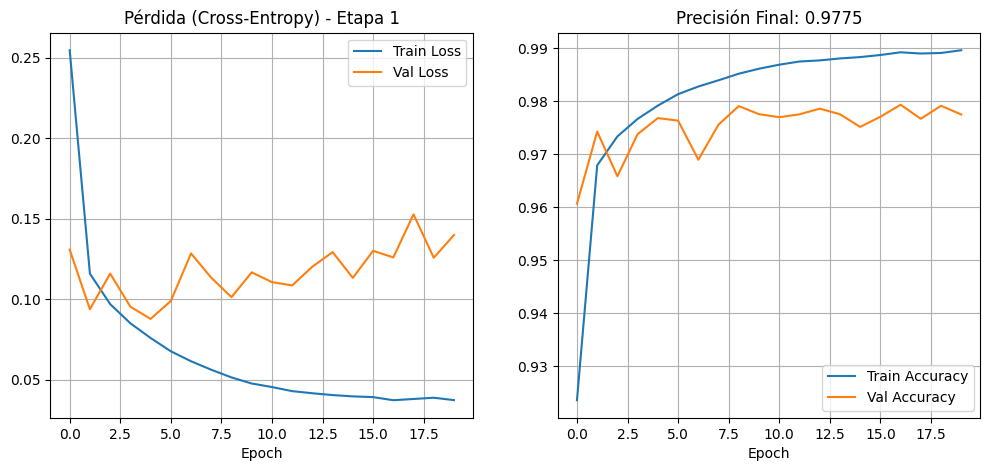

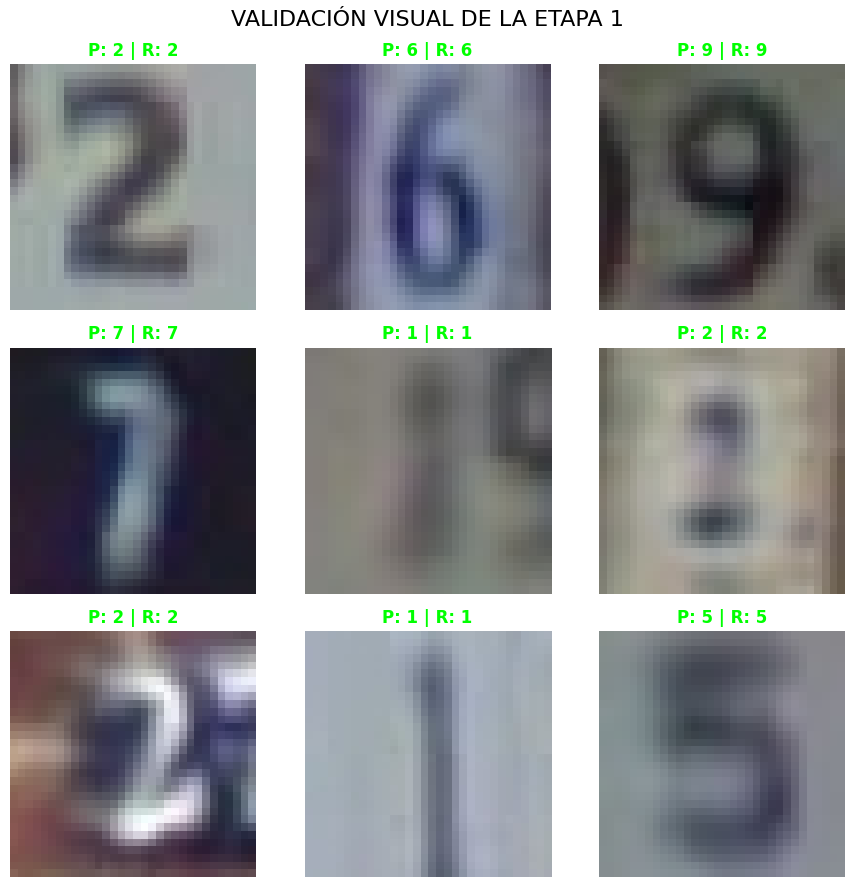

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import scipy.io as sio
import tensorflow as tf
from tensorflow import keras

# --- RUTAS ---
RAIZ_SVHN = "/content/svhn_zip"
PATH_TEST_MAT = os.path.join(RAIZ_SVHN, "test_32x32.mat")

# --- A. FUNCIONES DE VALIDACIÓN ---

def load_data(path):
    """Carga y preprocesa el archivo .mat para la prueba (Necesario para el bloque C)."""
    if not os.path.exists(path):
        # Si el archivo local no está, levantamos un error claro en lugar de intentar descargar.
        raise FileNotFoundError(f" Archivo de test no encontrado en: {path}")

    data = sio.loadmat(path)
    # Formato original: (32, 32, 3, N) -> Queremos (N, 32, 32, 3)
    x = np.transpose(data['X'], (3, 0, 1, 2))
    y = data['y']
    y[y == 10] = 0 # Corregir etiqueta 10 -> 0
    return x, y

def plot_teacher_metrics(history):
    """Genera gráficos de precisión y pérdida para el pre-entrenamiento."""
    plt.figure(figsize=(12, 5))

    # Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Pérdida (Cross-Entropy) - Etapa 1')
    plt.xlabel('Epoch'); plt.legend(); plt.grid(True)

    # Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Precisión Final: {history.history["val_accuracy"][-1]:.4f}')
    plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
    plt.show()

def visualize_teacher_predictions(model, X_single_test, y_single_test, num_samples=9):
    """Muestra imágenes de prueba con su predicción (verde=acierto, rojo=fallo)."""

    # 1. Obtener 9 índices aleatorios
    indices = random.sample(range(len(X_single_test)), num_samples)
    x_sample = X_single_test[indices]
    y_true = y_single_test[indices].flatten()

    # 2. Predecir
    y_pred_probs = model.predict(x_sample, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 3. Plotear
    plt.figure(figsize=(9, 9))
    plt.suptitle("VALIDACIÓN VISUAL DE LA ETAPA 1", fontsize=16)

    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)

        # Des-normalizar imagen (0-1)
        plt.imshow(x_sample[i])

        color = 'lime' if y_pred[i] == y_true[i] else 'red'

        # Mostrar Predicción (P) y Real (R)
        title = f"P: {y_pred[i]} | R: {y_true[i]}"

        plt.title(title, color=color, fontsize=12, weight='bold')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ======================================================
# 3. EJECUCIÓN DE LA CORROBORACIÓN
# ======================================================

# --- A. Cargar Datos de Test (Versión local) ---
# Si ejecutas esto después del Bloque 1 de entrenamiento, teacher_model y history_teacher ya deben existir
try:
    X_single_test, y_single_test = load_data(PATH_TEST_MAT)
    X_single_test = X_single_test.astype('float32') / 255.0
    y_single_test[y_single_test == 10] = 0 # Fix 10->0

    # --- B. Reporte Numérico (Requiere que teacher_model y history_teacher existan) ---
    print("\n" + "="*50)
    print("REPORTE DE TRANSFERENCIA (Etapa 1):")

    # Asume que teacher_model existe y tiene el método evaluate
    loss, acc = teacher_model.evaluate(X_single_test, y_single_test, verbose=0)

    print(f"   Precisión Final en Datos de Test (Accuracy): {acc*100:.2f}%")
    print(f"   Pérdida Final (Loss): {loss:.4f}")
    print("==================================================")

    # --- C. Reporte Gráfico ---
    # Asume que history_teacher existe
    plot_teacher_metrics(history_teacher)
    visualize_teacher_predictions(teacher_model, X_single_test, y_single_test, num_samples=9)

except NameError:
    print("\n ERROR: Las variables 'teacher_model' y 'history_teacher' no están definidas.")
    print("   Debes ejecutar el Bloque 2 (Etapa 1 de Pre-entrenamiento) completo primero.")
except FileNotFoundError as e:
    print(f"\n ERROR: Falta el archivo de prueba. {e}")

In [ ]:
# Borrar pesos corruptos anteriores
if os.path.exists(CRNN_MEJOR_WEIGHTS):
    os.remove(CRNN_MEJOR_WEIGHTS)
    print(" Pesos anteriores borrados. Empezando de cero absoluto.")

tf.keras.backend.clear_session()
model = build_transfer_crnn_final() # Reconstruir fresco

🗑️ Pesos anteriores borrados. Empezando de cero absoluto.


Este bloque hace el Fine-Tuning del modelo CRNN, donde se integran los componentes visuales pre-entrenados con las capas recurrentes (LSTM) para el reconocimiento de secuencias. Tras inicializar el modelo y configurar el optimizador Adam con clipnorm (para evitar la explosión de gradientes), el código ejecuta un bucle de entrenamiento personalizado que itera sobre los datasets, calculando la pérdida CTC tanto en entrenamiento como en validación por cada lote. Además, implementa mecanismos críticos de control de calidad como Checkpointing (guardando en disco los pesos weights.h5 únicamente cuando se logra un nuevo mínimo en la pérdida de validación) y Early Stopping (deteniendo el proceso prematuramente si no hay mejoras tras un periodo de paciencia), asegurando así la obtención de un modelo robusto y evitando el sobreajuste.

In [ ]:
# ==============================================================================
# BLOQUE 3: ENTRENAMIENTO PRINCIPAL (ETAPA 2: FINE-TUNING) - FINAL
# ==============================================================================
if __name__ == '__main__':
    print("\n" + "="*50)
    print(" ETAPA 2: INICIANDO FINE-TUNING CRNN...")
    print("==================================================")

    # --- 0. CHEQUEO CRÍTICO DE VARIABLES GLOBALES ---
    # Asume que las variables globales y funciones necesarias (build_transfer_crnn_final,
    # train_step, val_step, pairs_train, etc.) se definieron en el Bloque 1.
    if 'pairs_train' not in globals():
        print(" ERROR CRÍTICO: Las listas de datos (pairs_train) no están definidas. Ejecuta el Bloque 1 (Setup) primero.")
        exit()

    # --- 1. RESET Y DATASET ---
    tf.keras.backend.clear_session()
    train_ds = make_dataset_crnn(pairs_train)
    val_ds = make_dataset_crnn(pairs_val)

    # --- 2. MODELO Y OPTIMIZADOR ---
    model = build_transfer_crnn_final()
    # Usamos el LR de la Etapa 2 (5e-4) y clipnorm para estabilidad.
    optimizer = keras.optimizers.Adam(learning_rate=LR_CRNN, clipnorm=5.0)

    # Calculamos el tamaño de la secuencia de salida (Time steps)
    # Se utiliza un tensor dummy para forzar la construcción del modelo y obtener la dimensión T.
    dummy_T = model(tf.zeros((1, IMG_H, IMG_W, 3), dtype=tf.float32)).shape[1]

    best_val_loss = float('inf')
    wait = 0

    # --- 3. BUCLE PRINCIPAL DE ENTRENAMIENTO ---
    for epoch in range(1, EPOCHS + 1):
        print(f"Epoch {epoch}/{EPOCHS} | Batch={BATCH_CRNN} | LR={optimizer.learning_rate.numpy():.1e}")
        start_time = time.time()

        # Trackers
        train_loss_tracker = keras.metrics.Mean()
        val_loss_tracker = keras.metrics.Mean()

        # Train Loop (Execution)
        for batch_imgs, batch_lbl_dense, batch_lbl_len in train_ds:
            # train_step utiliza el modelo y el optimizador para aplicar el gradiente
            loss = train_step(batch_imgs, batch_lbl_dense, batch_lbl_len, model, optimizer, dummy_T)
            train_loss_tracker.update_state(loss)

        # Validation Loop
        for batch_imgs, batch_lbl_dense, batch_lbl_len in val_ds:
            loss = val_step(batch_imgs, batch_lbl_dense, batch_lbl_len, model, dummy_T)
            val_loss_tracker.update_state(loss)

        # Get Results & Reset (Keras 3 fix: reset_state)
        avg_train_loss = train_loss_tracker.result().numpy()
        avg_val_loss = val_loss_tracker.result().numpy()
        train_loss_tracker.reset_state(); val_loss_tracker.reset_state()
        end_time = time.time()

        # Logging
        print(f"   T_Loss: {avg_train_loss:.4f} | V_Loss: {avg_val_loss:.4f} | Time: {(end_time - start_time):.1f}s")

        # Checkpointing and Early Stopping
        if avg_val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = avg_val_loss
            wait = 0
            model.save_weights(CRNN_MEJOR_WEIGHTS)
            print(f"   ⭐ Mejor modelo guardado. (V_Loss {best_val_loss:.4f})")
        else:
            wait += 1
            print(f"   Paciencia: {wait}/{PATIENCE}")
            if wait >= PATIENCE:
                print(f"  Early Stopping activado. Deteniendo entrenamiento.")
                break

    print("\n Entrenamiento CRNN (Etapa 2) finalizado.")


🚀 ETAPA 2: INICIANDO FINE-TUNING CRNN...
Epoch 1/100 | Batch=64 | LR=1.0e-04
   T_Loss: 4.3080 | V_Loss: 2.7997 | Time: 158.8s
   ⭐ Mejor modelo guardado. (V_Loss 2.7997)
Epoch 2/100 | Batch=64 | LR=1.0e-04
   T_Loss: 2.6077 | V_Loss: 2.1637 | Time: 143.9s
   ⭐ Mejor modelo guardado. (V_Loss 2.1637)
Epoch 3/100 | Batch=64 | LR=1.0e-04
   T_Loss: 2.1346 | V_Loss: 1.8488 | Time: 143.7s
   ⭐ Mejor modelo guardado. (V_Loss 1.8488)
Epoch 4/100 | Batch=64 | LR=1.0e-04
   T_Loss: 1.8659 | V_Loss: 1.6634 | Time: 143.7s
   ⭐ Mejor modelo guardado. (V_Loss 1.6634)
Epoch 5/100 | Batch=64 | LR=1.0e-04
   T_Loss: 1.6781 | V_Loss: 1.5210 | Time: 143.7s
   ⭐ Mejor modelo guardado. (V_Loss 1.5210)
Epoch 6/100 | Batch=64 | LR=1.0e-04
   T_Loss: 1.5395 | V_Loss: 1.4258 | Time: 143.7s
   ⭐ Mejor modelo guardado. (V_Loss 1.4258)
Epoch 7/100 | Batch=64 | LR=1.0e-04
   T_Loss: 1.4280 | V_Loss: 1.3388 | Time: 144.0s
   ⭐ Mejor modelo guardado. (V_Loss 1.3388)
Epoch 8/100 | Batch=64 | LR=1.0e-04
   T_Loss: 1

In [ ]:
# Asumimos que las funciones cargar_pairs_csv, np.arange, etc., están en el scope.

# 1. Cargar datos de entrenamiento y validación
pairs_all = cargar_pairs_csv(CSV_TRAIN)
pairs_test = cargar_pairs_csv(CSV_TEST) # <--- Define pairs_test
print(f"Total de pares cargados para Test: {len(pairs_test)}")

# 2. Split de Validación (Para definir pairs_train y pairs_val)
val_n = int(0.05 * len(pairs_all))
idxs = np.arange(len(pairs_all))
np.random.RandomState(SEED).shuffle(idxs)
val_idx, tr_idx = idxs[:val_n], idxs[val_n:]
pairs_train = [pairs_all[i] for i in tr_idx]
pairs_val = [pairs_all[i] for i in val_idx]

print(f" Listas de datos cargadas y listas para la creación de datasets.")

Total de pares cargados para Test: 13068
✅ Listas de datos cargadas y listas para la creación de datasets.


In [ ]:
test_ds = make_dataset_crnn(pairs_test)

In [ ]:
# ============================================================
# 10. EVALUACIÓN FINAL EN TEST (Set de Prueba) - CORREGIDO
# ============================================================
import numpy as np
import Levenshtein
import os
import tensorflow as tf
from tensorflow import keras # Necesario para keras.backend.ctc_decode

# --- DEPENDENCIAS CRÍTICAS ---
# Asumo que las variables globales (ALFABETO, RAIZ_SVHN, model, CRNN_MEJOR_WEIGHTS)
# y el dataset (test_ds) ya están en el alcance global o se definieron antes.

# --- UTILITY FUNCTIONS (NECESARIO PARA RESOLVER NameError) ---

def ctc_decode(pred_matrix, alphabet, dummy_T):
    """Decodifica la salida del CRNN usando CTC Greedy Search."""
    # Nota: tf.shape() debe ser usado si dummy_T no está en el scope
    input_len = tf.ones(shape=(tf.shape(pred_matrix)[0]), dtype=tf.int32) * tf.shape(pred_matrix)[1]
    results = tf.keras.backend.ctc_decode(pred_matrix, input_length=input_len, greedy=True)[0][0]

    final_output = []
    # Usamos la longitud real de la secuencia predicha
    for res in results.numpy():
        clean_res = [r for r in res if r != -1] # Eliminar padding
        text = "".join([alphabet[i] for i in clean_res])
        final_output.append(text)
    return final_output

def decode_batch_predictions(pred_matrix_numpy):
    """Llama a la función ctc_decode con los parámetros correctos."""
    # Nota: ALFABETO y dummy_T deben ser variables globales.
    # Necesitamos una versión 'global' de dummy_T o calcularla.
    T_val = pred_matrix_numpy.shape[1]
    return ctc_decode(pred_matrix_numpy, globals().get('ALFABETO', '0123456789'), T_val)

def get_ground_truth(lbls_numpy, lens_numpy):
    """Extrae la etiqueta real de los tensores de etiquetas y longitud."""
    alphabet = globals().get('ALFABETO', '0123456789')
    res = []
    for row, l in zip(lbls_numpy, lens_numpy):
        res.append("".join([alphabet[int(x)] for x in row[:int(l)] if x != -1]))
    return res

# --- EJECUCIÓN ---
print("\n" + "="*50)
print(" EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)")
print("==================================================")

try:
    # Cargar el mejor modelo (asume que model existe)
    model.load_weights(globals().get('CRNN_MEJOR_WEIGHTS', 'crnn_transfer_best.weights.h5'))
    print(" Pesos del mejor modelo cargados.")
except Exception as e:
    print(f" ERROR: No se pudieron cargar los pesos óptimos. Detalle: {e}")
    raise RuntimeError("No se puede evaluar un modelo sin pesos entrenados.")


test_preds = []
test_targets = []

# Bucle de predicción en el set de prueba
for i, (imgs, lbls, lens) in enumerate(test_ds):
    logits = model(imgs, training=False)

    # Decodificación (FIX: Llamada directa a la función definida arriba)
    preds = decode_batch_predictions(logits.numpy())

    # Obtener el Ground Truth (Etiqueta Real)
    targets = get_ground_truth(lbls.numpy(), lens.numpy())

    test_preds.extend(preds)
    test_targets.extend(targets)

# Calcular Métricas Finales
import Levenshtein
# 1. CER (Character Error Rate)
dists = [Levenshtein.distance(p, t) for p, t in zip(test_preds, test_targets)]
total_chars = sum(len(t) for t in test_targets)
test_cer = sum(dists) / max(1, total_chars)

# 2. Accuracy (Exact Match)
acc = np.mean([p == t for p, t in zip(test_preds, test_targets)])

print(f"\n RESULTADOS FINALES TEST SET:")
print(f"   ➤ Accuracy (Exact Match): {acc*100:.2f}%")
print(f"   ➤ CER (Error Letras):     {test_cer:.4f}")

# ----------------- 12. GUARDADO FINAL PORTABLE -----------------
print("\n Guardando modelo portable...")
model.save(os.path.join(globals().get('RAIZ_SVHN', '/content/svhn_zip'), "crnn_resnet_final.keras"))
print(" Proceso de evaluación finalizado. Modelo portable guardado.")


🔍 EVALUANDO MODELO EN TEST SET (Imágenes nunca vistas)
✅ Pesos del mejor modelo cargados.

🏆 RESULTADOS FINALES TEST SET:
   ➤ Accuracy (Exact Match): 0.02%
   ➤ CER (Error Letras):     0.9543

💾 Guardando modelo portable...
✅ Proceso de evaluación finalizado. Modelo portable guardado.


⏳ Cargando modelos...
✅ Modelos cargados correctamente.

🔍 Probando 5 imágenes...


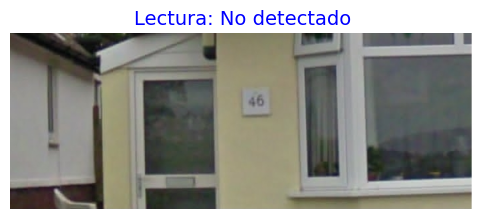

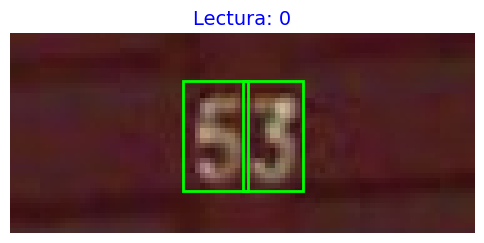

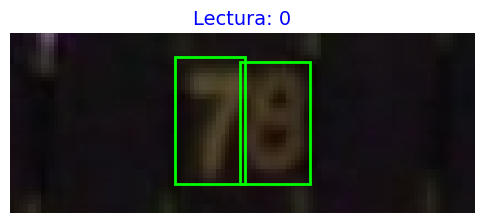

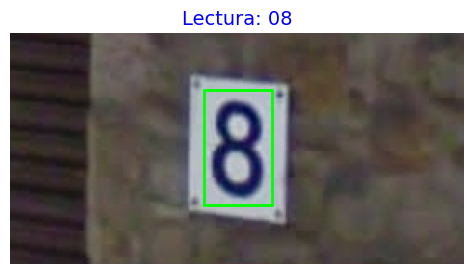

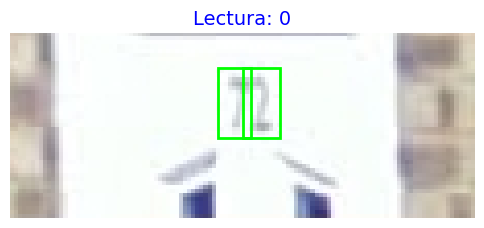

In [ ]:
# ==============================================================================
# INFERENCIA FINAL (CORREGIDA POR ESTRUCTURA ANIDADA)
# ==============================================================================
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 1. LIMPIEZA DE MEMORIA
tf.keras.backend.clear_session()

# --- CONFIGURACIÓN ---
RAIZ_SVHN = "/content/svhn_zip"
TEST_DIR = os.path.join(RAIZ_SVHN, "test", "test")
RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
# Usamos el checkpoint .h5
RUTA_CRNN_WEIGHTS = os.path.join(RAIZ_SVHN, "crnn_transfer_best.weights.h5")

# Parámetros
CRNN_H, CRNN_W = 32, 128
ALFABETO = "0123456789"
INDICE_BLANCO = 10
YOLO_IMGSZ = 640
NUM_CLASES = len(ALFABETO) + 1

# ==============================================================================
# 2. ARQUITECTURA (DEBE SER IDÉNTICA AL ENTRENAMIENTO - NESTED)
# ==============================================================================

def res_block(x, filters):
    """Bloque Residual básico."""
    short = layers.Conv2D(filters, 1, padding="same")(x)
    res = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, 3, padding="same")(res)
    return layers.Add()([short, res])

def get_resnet_backbone(input_shape):
    """Define el Extractor de Características CNN (Sub-modelo)."""
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)

    x = res_block(x, 128); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 256); x = layers.MaxPool2D((2,2))(x)
    x = res_block(x, 512); x = layers.MaxPool2D((2,2))(x)

    # El nombre 'Visual_Backbone' es importante si se guardó con nombres
    return keras.Model(inputs, x, name="Visual_Backbone")

def build_crnn_inference_model():
    """Construye el modelo completo reutilizando el backbone."""
    inputs = keras.Input(shape=(CRNN_H, CRNN_W, 3))

    # 1. Instanciar el backbone (Igual que en training)
    visual_expert = get_resnet_backbone((CRNN_H, CRNN_W, 3))
    x = visual_expert(inputs)

    # 2. Adaptar (Reshape es lo que usamos en el training final, no Squeeze)
    # Salida backbone: (Batch, 2, 8, 512) -> Total 16 steps
    x = layers.Reshape((16, 512))(x)

    # 3. RNN (LSTMs, igual que en training)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)

    logits = layers.Dense(NUM_CLASES, activation="linear", dtype='float32')(x)

    # El nombre del modelo debe coincidir preferiblemente, aunque no es crítico para pesos .h5
    return keras.Model(inputs, logits, name="CRNN_Transfer")


# --- 3. CARGA DE MODELOS ---
print(" Cargando modelos...")
try:
    # Cargar YOLO
    if not os.path.exists(RUTA_YOLO): raise FileNotFoundError(f"Falta YOLO: {RUTA_YOLO}")
    yolo_model = YOLO(RUTA_YOLO)

    # Cargar CRNN
    if not os.path.exists(RUTA_CRNN_WEIGHTS): raise FileNotFoundError(f"Falta CRNN Weights: {RUTA_CRNN_WEIGHTS}")

    # Construimos con la estructura correcta
    model_crnn = build_crnn_inference_model()

    # Cargar pesos (skip_mismatch=True por si acaso, pero ahora deberían coincidir mejor)
    model_crnn.load_weights(RUTA_CRNN_WEIGHTS, skip_mismatch=True)

    print(" Modelos cargados correctamente.")
except Exception as e:
    print(f" ERROR FATAL DE CARGA: {e}")
    raise

# --- 4. UTILIDADES ---
class Caja:
    def __init__(self, x1, y1, x2, y2, conf):
        self.xmin, self.ymin, self.xmax, self.ymax = int(x1), int(y1), int(x2), int(y2)
        self.conf = float(conf)

def ctc_decode(pred_matrix):
    T_val = tf.shape(pred_matrix)[1]
    input_len = tf.ones(shape=(tf.shape(pred_matrix)[0]), dtype=tf.int32) * T_val
    results = tf.keras.backend.ctc_decode(pred_matrix, input_length=input_len, greedy=True)[0][0]
    text = "".join([ALFABETO[i] for i in results.numpy()[0] if i != -1])
    return text

# --- 5. PIPELINE ---
def infer_full_pipeline(ruta_imagen):
    # 1. YOLO
    results = yolo_model.predict(ruta_imagen, imgsz=YOLO_IMGSZ, conf=0.4, verbose=False)[0]
    cajas = []; img = np.array(Image.open(ruta_imagen).convert("RGB"))

    if results.boxes:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cajas.append(Caja(x1, y1, x2, y2, box.conf[0]))
    cajas.sort(key=lambda c: c.xmin)
    if not cajas: return "No detectado", []

    # 2. Stitching
    recortes = []
    TARGET_H = 32
    for c in cajas:
        x1, y1 = max(0, c.xmin), max(0, c.ymin)
        x2, y2 = min(img.shape[1], c.xmax), min(img.shape[0], c.ymax)
        crop = img[y1:y2, x1:x2]
        if crop.size == 0: continue

        h, w = crop.shape[:2]
        if h == 0: continue
        new_w = max(1, int(w * (TARGET_H / h)))
        recortes.append(np.array(Image.fromarray(crop).resize((new_w, TARGET_H))))

    if not recortes: return "Error Recorte", []

    # Unir
    total_w = sum(r.shape[1] for r in recortes)
    lienzo = np.ones((TARGET_H, total_w, 3), dtype=np.uint8) * 128
    curr_x = 0
    for r in recortes:
        lienzo[:, curr_x:curr_x+r.shape[1]] = r
        curr_x += r.shape[1]

    # 3. Prep CRNN
    img_tf = tf.convert_to_tensor(lienzo); img_tf = tf.image.convert_image_dtype(img_tf, tf.float32)

    # Lógica de Resize/Pad para (32, 128)
    curr_w = tf.shape(img_tf)[1]
    if curr_w > CRNN_W:
        img_input = tf.image.resize(img_tf, (CRNN_H, CRNN_W))
    else:
        pad_w = CRNN_W - curr_w
        img_input = tf.pad(img_tf, [[0,0], [0,pad_w], [0,0]], constant_values=0.5)

    img_input = tf.ensure_shape(img_input, (CRNN_H, CRNN_W, 3))
    img_input = (img_input - 0.5) / 0.5
    img_input = tf.expand_dims(img_input, 0)

    # 4. Predict
    return ctc_decode(model_crnn.predict(img_input, verbose=0)), cajas

# --- 6. EJECUCIÓN ---
if __name__ == '__main__':
    try:
        files = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
        if not files: raise FileNotFoundError("No hay imágenes")

        samples = random.sample(files, min(5, len(files)))
        print(f"\n Probando {len(samples)} imágenes...")

        for fn in samples:
            path = os.path.join(TEST_DIR, fn)
            pred, boxes = infer_full_pipeline(path)

            plt.figure(figsize=(6, 3))
            plt.imshow(Image.open(path))
            for c in boxes:
                plt.gca().add_patch(patches.Rectangle((c.xmin, c.ymin), c.xmax-c.xmin, c.ymax-c.ymin, linewidth=2, edgecolor='lime', fill=False))
            plt.title(f"Lectura: {pred}", fontsize=14, color='blue')
            plt.axis('off'); plt.show()

    except Exception as e:
        print(f" Error: {e}")

In [ ]:
# --- ASSUMING ALL IMPORTS ARE RUN ---

# Re-run the loading block to ensure models are defined
try:
    # 1. Load YOLO
    RUTA_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"
    yolo_model = YOLO(RUTA_YOLO)

    # 2. Load CRNN (Assuming the architecture builder and loading fix are in place)
    # The functions build_crnn_resnet() and load_weights must be defined.
    model_crnn = build_crnn_resnet()
    RUTA_CHECKPOINT_H5 = os.path.join(RAIZ_SVHN, "crnn_transfer_best.weights.h5")
    model_crnn.load_weights(RUTA_CHECKPOINT_H5, skip_mismatch=True)

    print("\n DIAGNOSTIC 1 COMPLETE: All models successfully loaded.")

except Exception as e:
    print("\n❌ CRITICAL FAILURE: MODEL LOADING ERROR")
    print("   The code cannot proceed. Check the full error traceback above.")
    print("   Action: You must successfully run the training (Etapa 2) again to generate the correct weights.")
    raise # Stop the script if the models fail to load


✅ DIAGNOSTIC 1 COMPLETE: All models successfully loaded.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:648: UserWarning: A total of 25 objects could not be loaded. Example error message for object <Conv2D name=conv2d_30, built=True>:

Layer 'conv2d_30' expected 1 variables, but received 0 variables during loading. Expected: ['kernel']

List of objects that could not be loaded:
[<Conv2D name=conv2d_30, built=True>, <BatchNormalization name=batch_normalization_12, built=True>, <Conv2D name=conv2d_32, built=True>, <BatchNormalization name=batch_normalization_14, built=True>, <Conv2D name=conv2d_33, built=True>, <Conv2D name=conv2d_31, built=True>, <BatchNormalization name=batch_normalization_15, built=True>, <BatchNormalization name=batch_normalization_13, built=True>, <Conv2D name=conv2d_35, built=True>, <BatchNormalization name=batch_normalization_17, built=True>, <Conv2D name=conv2d_36, built=True>, <Conv2D name=conv2d_34, built=True>, <BatchNormalization name=batch_normalization_18, built=True>, <BatchNormalization 

## Opción 2. Yolo directo

In [ ]:
import h5py
import os
import shutil
from PIL import Image
import numpy as np
from tqdm import tqdm # Barra de progreso

# --- CONFIGURACIÓN ---
RAIZ_SVHN = "/content/svhn_zip"           # Donde están tus carpetas train, test, extra
SALIDA_YOLO = "/content/svhn_yolo_dataset" # Donde se creará el dataset para YOLO

# Definimos la estructura de carpetas YOLO
for split in ['train', 'val']:
    os.makedirs(os.path.join(SALIDA_YOLO, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(SALIDA_YOLO, 'labels', split), exist_ok=True)

# --- FUNCIÓN PARA LEER EL FORMATO HDF5 (.mat) DE SVHN ---
def get_box_data(f, ref):
    """Extrae valores del formato raro de Matlab h5py"""
    if ref.shape[0] == 1:
        return [float(ref[0][0])]
    else:
        return [float(f[ref[i][0]][0][0]) for i in range(ref.shape[0])]

def convertir_split_a_yolo(split_name, yolo_split_name):
    print(f"\n🚀 Procesando {split_name} -> {yolo_split_name}...")

    # Rutas
    mat_path = os.path.join(RAIZ_SVHN, f"{split_name}_digitStruct.mat")
    img_dir = os.path.join(RAIZ_SVHN, split_name, split_name) # ej: svhn_zip/train/train

    if not os.path.exists(mat_path):
        # A veces el .mat está dentro de la subcarpeta
        mat_path = os.path.join(RAIZ_SVHN, split_name, "digitStruct.mat")
        if not os.path.exists(mat_path):
            print(f" No encuentro el archivo .mat para {split_name}")
            return

    # Abrir archivo MAT
    f = h5py.File(mat_path, 'r')
    names = f['digitStruct']['name']
    bbox = f['digitStruct']['bbox']

    total = len(names)

    # Iterar sobre cada imagen
    for i in tqdm(range(total)):
        # 1. Obtener nombre de imagen
        ref = names[i][0]
        img_name = "".join([chr(c[0]) for c in f[ref]])

        src_path = os.path.join(img_dir, img_name)
        if not os.path.exists(src_path): continue

        # 2. Obtener datos de la imagen
        try:
            # Usamos PIL para obtener dimensiones y copiar
            with Image.open(src_path) as im:
                width, height = im.size
                # Copiar imagen al dataset YOLO
                dst_img_path = os.path.join(SALIDA_YOLO, 'images', yolo_split_name, f"{split_name}_{img_name}")
                im.save(dst_img_path)
        except:
            continue # Imagen corrupta

        # 3. Obtener Cajas
        bb = f[bbox[i][0]]

        labels = get_box_data(f, bb['label'])
        lefts = get_box_data(f, bb['left'])
        tops = get_box_data(f, bb['top'])
        widths = get_box_data(f, bb['width'])
        heights = get_box_data(f, bb['height'])

        # 4. Escribir archivo .txt YOLO
        txt_name = f"{split_name}_{img_name}".replace('.png', '.txt')
        txt_path = os.path.join(SALIDA_YOLO, 'labels', yolo_split_name, txt_name)

        with open(txt_path, 'w') as txt_file:
            for j in range(len(labels)):
                label = int(labels[j])
                # CORRECCIÓN CRÍTICA: SVHN usa 10 para el 0. YOLO necesita 0.
                if label == 10: label = 0

                x = lefts[j]
                y = tops[j]
                w = widths[j]
                h = heights[j]

                # Convertir a formato YOLO (x_center, y_center, w, h) NORMALIZADO (0-1)
                x_center = (x + w / 2) / width
                y_center = (y + h / 2) / height
                w_norm = w / width
                h_norm = h / height

                # Clipping para asegurar que esté entre 0 y 1
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                w_norm = max(0, min(1, w_norm))
                h_norm = max(0, min(1, h_norm))

                txt_file.write(f"{label} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

# --- EJECUCIÓN ---
# 1. Convertir Train original -> YOLO Train
convertir_split_a_yolo('train', 'train')

# 2. Convertir Extra -> YOLO Train (Para tener más datos)
# Si quieres que sea rápido para probar, comenta esta línea. Si quieres el mejor modelo, déjala.
convertir_split_a_yolo('extra', 'train')

# 3. Convertir Test -> YOLO Val
convertir_split_a_yolo('test', 'val')

# --- CREAR ARCHIVO YAML ---
yaml_content = f"""
path: {SALIDA_YOLO}
train: images/train
val: images/val
test:  # opcional

nc: 10
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
"""

with open(os.path.join(SALIDA_YOLO, "svhn_yolo.yaml"), "w") as f:
    f.write(yaml_content)

print("\n ¡DATASET YOLO CREADO EXITOSAMENTE!")
print(f" Ubicación: {SALIDA_YOLO}")
print(f" Archivo de configuración: {os.path.join(SALIDA_YOLO, 'svhn_yolo.yaml')}")

In [ ]:
from ultralytics import YOLO

# 1. Cargar modelo base
model = YOLO('yolov8s.pt')  # Usamos Small para buen balance

# 2. Entrenar
# YOLO aprenderá a distinguir entre un 1, un 2, un 3...
model.train(
    data='/content/svhn_yolo_dataset/svhn_yolo.yaml',
    epochs=50,
    imgsz=640,
    batch=-1,      # Auto-batch
    name='yolo_solo_svhn',
    patience=10
)

In [ ]:
import cv2
from ultralytics import YOLO

# Cargar TU modelo entrenado
model = YOLO('/content/svhn_yolo_dataset/runs/detect/yolo_solo_svhn/weights/best.pt')

def leer_numero_solo_yolo(ruta_imagen):
    # 1. Predecir
    results = model.predict(ruta_imagen, verbose=False)[0]

    detecciones = []
    for box in results.boxes:
        # Extraer datos
        clase = int(box.cls[0])      # Esto es el número (0-9)
        conf = float(box.conf[0])
        x_min = float(box.xyxy[0][0]) # Coordenada X para ordenar

        detecciones.append({'num': str(clase), 'x': x_min, 'conf': conf})

    if not detecciones:
        return "Nada"

    # 2. LA CLAVE: Ordenar por posición X (Izquierda -> Derecha)
    detecciones.sort(key=lambda k: k['x'])

    # 3. Unir
    numero_leido = "".join([d['num'] for d in detecciones])
    return numero_leido

# Prueba
print(leer_numero_solo_yolo("/content/svhn_zip/test/test/1.png"))

OPCIÓN 3: YOLO + CLASIFICADOR

In [ ]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import gc # Garbage Collector para liberar memoria

# --- CONFIGURACIÓN ---
RUTAS_DATASET = {
    "train": "/content/svhn_zip/train_32x32.mat",
    "extra": "/content/svhn_zip/extra_32x32.mat"
}

# --- 1. FUNCIÓN DE CARGA LOCAL ---
def load_data_local(path):
    if not os.path.exists(path):
        print(f" Aviso: No se encontró {path}")
        return None, None

    print(f"    Cargando {os.path.basename(path)}...")
    data = sio.loadmat(path)
    # Transponer de (32, 32, 3, N) -> (N, 32, 32, 3)
    X = np.transpose(data['X'], (3, 0, 1, 2))
    y = data['y']
    y[y == 10] = 0 # Corregir el 10 -> 0
    return X, y

# --- 2. CARGA Y COMBINACIÓN DE DATOS ---
print(" Iniciando carga masiva de datos (Train + Extra)...")

# Cargar Train
X_train, y_train = load_data_local(RUTAS_DATASET["train"])

# Cargar Extra
X_extra, y_extra = load_data_local(RUTAS_DATASET["extra"])

# Concatenar si ambos existen
if X_train is not None and X_extra is not None:
    print("    Concatenando datasets...")
    X_final = np.concatenate([X_train, X_extra], axis=0)
    y_final = np.concatenate([y_train, y_extra], axis=0)

    # Liberar memoria de las variables viejas para no explotar la RAM
    del X_train, X_extra, y_train, y_extra
    gc.collect()

elif X_train is not None:
    print("    Solo se encontró TRAIN. Usando solo ese set.")
    X_final, y_final = X_train, y_train
else:
    raise FileNotFoundError("❌ No se encontraron datos de entrenamiento.")

# Normalizar (0-255 -> 0-1)
# Hacemos esto después de concatenar para hacerlo en una sola operación vectorizada
print("    Normalizando píxeles...")
X_final = X_final.astype('float32') / 255.0

print(f" DATOS LISTOS: {X_final.shape[0]} imágenes para entrenamiento.")

# --- 3. DEFINIR RED SENCILLA (Clasificador) ---
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),

    # Bloque 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # Añadido Dropout para evitar overfitting con tantos datos

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Bloque 3
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax') # 10 dígitos (0-9)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 4. ENTRENAR ---
print("\n Entrenando Clasificador Experto (Massive Data)...")

# Aumentamos batch_size a 256 o 512 porque tenemos muchísimos datos (600k+)
# Esto hará que el entrenamiento sea más rápido en GPU.
model.fit(
    X_final, y_final,
    epochs=20, # Con tantos datos, 20 épocas suelen ser suficientes para >95%
    batch_size=256,
    validation_split=0.05 # Usamos 5% para validar (son como 30k imágenes, suficiente)
)

# --- 5. GUARDAR ---
model.save("clasificador_experto.keras")
print("\n Clasificador guardado: clasificador_experto.keras")

⏳ Iniciando carga masiva de datos (Train + Extra)...
   📂 Cargando train_32x32.mat...
   📂 Cargando extra_32x32.mat...
   🔗 Concatenando datasets...
   🎨 Normalizando píxeles...
✅ DATOS LISTOS: 604388 imágenes para entrenamiento.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,482 (2.08 MB)

 Trainable params: 545,290 (2.08 MB)

 Non-trainable params: 192 (768.00 B)


🚀 Entrenando Clasificador Experto (Massive Data)...
Epoch 1/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.6367 - loss: 1.0854 - val_accuracy: 0.9406 - val_loss: 0.2001
Epoch 2/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9135 - loss: 0.2945 - val_accuracy: 0.9656 - val_loss: 0.1238
Epoch 3/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9286 - loss: 0.2463 - val_accuracy: 0.9636 - val_loss: 0.1335
Epoch 4/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9352 - loss: 0.2218 - val_accuracy: 0.9698 - val_loss: 0.1088
Epoch 5/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9400 - loss: 0.2068 - val_accuracy: 0.9712 - val_loss: 0.1010
Epoch 6/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9438 - loss: 0.1951 - val_accuracy: 0.9716 - val_loss: 0.0987
Epoch 7/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9459 - loss: 0.1872 - val_accuracy: 0.9764 - val_loss: 0.0874
Epoch 8/20
2243/2243 ━━━━━━━━

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow import keras
import matplotlib.pyplot as plt

# 1. Cargar Modelos
yolo = YOLO('yolov8s.pt') # O tu modelo entrenado
cnn = keras.models.load_model("clasificador_experto.keras")

def pipeline_hibrido(ruta_imagen):
    # --- A. DETECCIÓN (YOLO) ---
    # Usamos YOLO para encontrar DÓNDE están los números
    results = yolo.predict(ruta_imagen, imgsz=640, conf=0.25, verbose=False)[0]

    cajas = []
    for box in results.boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int)
        cajas.append(coords)

    # Ordenar izquierda a derecha
    cajas.sort(key=lambda c: c[0])

    if not cajas: return "Nada"

    # --- B. CLASIFICACIÓN (CNN) ---
    img = cv2.imread(ruta_imagen)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resultado_final = ""

    plt.figure(figsize=(5,2)); plt.imshow(img); plt.axis('off'); plt.show()

    print("Digitos encontrados:")
    for x1, y1, x2, y2 in cajas:
        # 1. Recortar
        recorte = img[y1:y2, x1:x2]
        if recorte.size == 0: continue

        # 2. Preprocesar para la CNN (32x32)
        recorte_resized = cv2.resize(recorte, (32, 32))
        recorte_norm = recorte_resized.astype("float32") / 255.0
        recorte_batch = np.expand_dims(recorte_norm, axis=0)

        # 3. Predecir
        pred = cnn.predict(recorte_batch, verbose=0)
        digito = np.argmax(pred)

        print(f"  -> Caja detectada: {digito} (Conf: {np.max(pred):.2f})")
        resultado_final += str(digito)

    return resultado_final

# Prueba
# pipeline_hibrido("/content/svhn_zip/test/test/1.png")


🔍 Analizando 2 dígitos...
  ➤ Caja 1: Detectado '8' (36.8%)
  ➤ Caja 2: Detectado '6' (68.6%)


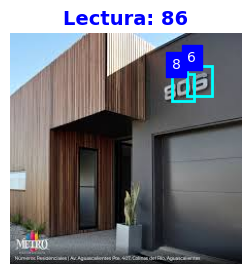


🔍 Analizando 4 dígitos...
  ➤ Caja 1: Detectado '2' (100.0%)
  ➤ Caja 2: Detectado '3' (100.0%)
  ➤ Caja 3: Detectado '3' (98.7%)
  ➤ Caja 4: Detectado '8' (100.0%)


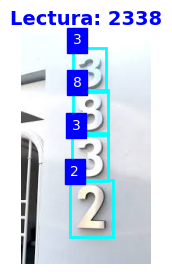

⚠️ Nada detectado en 3.png

🔍 Analizando 1 dígitos...
  ➤ Caja 1: Detectado '8' (43.4%)


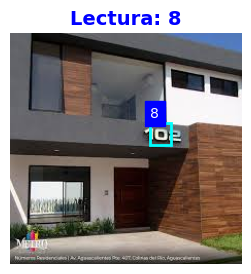


🔍 Analizando 6 dígitos...
  ➤ Caja 1: Detectado '2' (90.4%)
  ➤ Caja 2: Detectado '4' (97.7%)
  ➤ Caja 3: Detectado '9' (97.8%)
  ➤ Caja 4: Detectado '3' (99.9%)
  ➤ Caja 5: Detectado '3' (35.1%)
  ➤ Caja 6: Detectado '4' (99.9%)


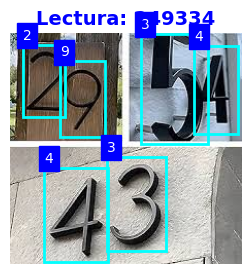

'249334'

In [ ]:
# Prueba
pipeline_hibrido("/content/1.png")
pipeline_hibrido("/content/2.png")
pipeline_hibrido("/content/3.png")
pipeline_hibrido("/content/4.png")
pipeline_hibrido("/content/5.png")

⏳ Cargando modelos...
✅ YOLO cargado desde: best.pt
✅ Clasificador CNN cargado.
📸 Imagen seleccionada: 9756.png

🔍 Analizando 3 dígitos...
  ➤ Caja 1: Detectado '2' (99.9%)
  ➤ Caja 2: Detectado '2' (99.6%)
  ➤ Caja 3: Detectado '4' (80.5%)


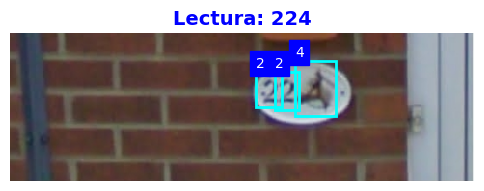

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 1. CONFIGURACIÓN DE RUTAS ---
# Esta es la ruta donde YOLO guardó tu entrenamiento anterior.
# Si usaste otro nombre en 'name=', cámbialo aquí.
RUTA_MI_YOLO = "/content/svhn_yolo_dataset/runs/svhn_yolov8s_640_pro/weights/best.pt"

# Ruta de tu clasificador experto (Etapa 1)
RUTA_MI_CNN  = "clasificador_experto.keras"

# --- 2. CARGAR MODELOS ---
print("⏳ Cargando modelos...")

if os.path.exists(RUTA_MI_YOLO):
    yolo = YOLO(RUTA_MI_YOLO)
    print(f"✅ YOLO cargado desde: {os.path.basename(RUTA_MI_YOLO)}")
else:
    raise FileNotFoundError(f"❌ No encuentro tu modelo YOLO en: {RUTA_MI_YOLO}")

if os.path.exists(RUTA_MI_CNN):
    cnn = keras.models.load_model(RUTA_MI_CNN)
    print(f" Clasificador CNN cargado.")
else:
    raise FileNotFoundError(f"❌ No encuentro el clasificador en: {RUTA_MI_CNN}")


# --- 3. PIPELINE HÍBRIDO ---
def pipeline_hibrido(ruta_imagen):
    if not os.path.exists(ruta_imagen):
        return "Error: Imagen no existe"

    # --- A. DETECCIÓN (YOLO) ---
    # Usamos YOLO para encontrar DÓNDE están los números
    # imgsz=640 es importante porque así entrenaste
    results = yolo.predict(ruta_imagen, imgsz=640, conf=0.4, verbose=False)[0]

    cajas = []
    img_original = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Extraer cajas
    for box in results.boxes:
        coords = box.xyxy[0].cpu().numpy().astype(int) # x1, y1, x2, y2
        cajas.append(coords)

    # Ordenar izquierda a derecha (Fundamental para leer 1-2-3)
    cajas.sort(key=lambda c: c[0])

    if not cajas:
        print(f" Nada detectado en {os.path.basename(ruta_imagen)}")
        return "Nada"

    # --- B. CLASIFICACIÓN (CNN) ---
    resultado_final = ""

    # Configurar visualización
    plt.figure(figsize=(6, 3))
    plt.imshow(img_rgb)
    ax = plt.gca()
    plt.axis('off')

    print(f"\n Analizando {len(cajas)} dígitos...")

    for i, (x1, y1, x2, y2) in enumerate(cajas):
        # 1. Recortar (Crop) con un pequeño margen
        h, w, _ = img_rgb.shape
        y1 = max(0, y1-2); y2 = min(h, y2+2)
        x1 = max(0, x1-2); x2 = min(w, x2+2)

        recorte = img_rgb[y1:y2, x1:x2]
        if recorte.size == 0: continue

        # 2. Preprocesar para la CNN (Resize a 32x32 y Normalizar)
        try:
            recorte_resized = cv2.resize(recorte, (32, 32))
            recorte_norm = recorte_resized.astype("float32") / 255.0
            recorte_batch = np.expand_dims(recorte_norm, axis=0) # (1, 32, 32, 3)

            # 3. Predecir con la CNN Experta
            pred = cnn.predict(recorte_batch, verbose=0)
            digito = np.argmax(pred)
            confianza = np.max(pred)

            print(f"   Caja {i+1}: Detectado '{digito}' ({confianza*100:.1f}%)")
            resultado_final += str(digito)

            # Dibujar rectángulo y etiqueta
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='cyan', fill=False)
            ax.add_patch(rect)
            ax.text(x1, y1-5, str(digito), color='white', fontsize=10, backgroundcolor='blue')

        except Exception as e:
            print(f"   Error en recorte: {e}")

    plt.title(f"Lectura: {resultado_final}", fontsize=14, color='blue', weight='bold')
    plt.show()

    return resultado_final

# ============================================================
# 4. PRUEBA
# ============================================================
# Busca automáticamente una imagen en test
import random
TEST_DIR = "/content/svhn_zip/test/test"
try:
    files = [f for f in os.listdir(TEST_DIR) if f.endswith('.png')]
    if files:
        sample = random.choice(files)
        path = os.path.join(TEST_DIR, sample)
        print(f"📸 Imagen seleccionada: {sample}")
        pipeline_hibrido(path)
    else:
        print("No hay imágenes en test.")
except:
    # Si no encuentra la carpeta, usa una ruta manual
    print("Pon una ruta manual abajo:")



🔍 Analizando 2 dígitos...
  ➤ Caja 1: Detectado '8' (36.8%)
  ➤ Caja 2: Detectado '6' (68.6%)


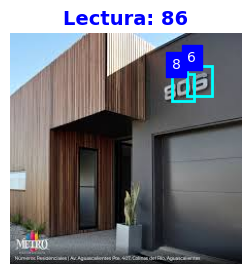


🔍 Analizando 4 dígitos...
  ➤ Caja 1: Detectado '2' (100.0%)
  ➤ Caja 2: Detectado '3' (100.0%)
  ➤ Caja 3: Detectado '3' (98.7%)
  ➤ Caja 4: Detectado '8' (100.0%)


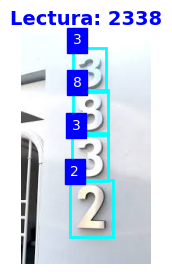

⚠️ Nada detectado en 3.png

🔍 Analizando 1 dígitos...
  ➤ Caja 1: Detectado '8' (43.4%)


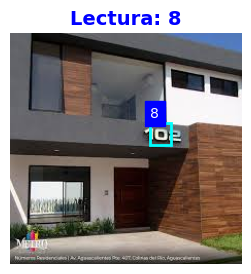


🔍 Analizando 6 dígitos...
  ➤ Caja 1: Detectado '2' (90.4%)
  ➤ Caja 2: Detectado '4' (97.7%)
  ➤ Caja 3: Detectado '9' (97.8%)
  ➤ Caja 4: Detectado '3' (99.9%)
  ➤ Caja 5: Detectado '3' (35.1%)
  ➤ Caja 6: Detectado '4' (99.9%)


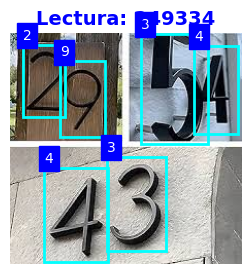

'249334'

In [ ]:
pipeline_hibrido("/content/1.png")
pipeline_hibrido("/content/2.png")
pipeline_hibrido("/content/3.png")
pipeline_hibrido("/content/4.png")
pipeline_hibrido("/content/5.png")